# Image (Face) Generation with Autoencoders

This project demonstrates the use of three different Autoencoder architectures to generate and reconstruct human faces from a dataset sourced from Hugging Face. The models include a basic linear Autoencoder, a Convolutional Autoencoder, and a Variational Autoencoder (VAE). Each model was trained to compress high-dimensional facial image data into lower-dimensional representations and then reconstruct the images from these compressed forms. The goal is to explore the effectiveness of different autoencoder designs in learning compact, meaningful representations of facial features, which can be used for tasks like image denoising, generation, or anomaly detection.


In [1]:
from datasets import load_dataset,DatasetDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io
import os
from PIL import Image
import random
import torchvision.transforms as transforms
import utils
import torch.nn as nn
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import time

/home/omar/TUM/05_projects/Image_generation_with_VAE/vae_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download and split the dataset into train,test and validation sets. 

In [2]:
ds = load_dataset("Karthik11232/human_face_generation")
#split the dataset 
train_test_set = ds['train'].train_test_split(test_size=0.1)
#print(train_test_set)
train_val_set = train_test_set['train'].train_test_split(test_size=0.1)

ds = DatasetDict({
    'train': train_test_set['train'],
    'test': train_test_set['test'],
    'validation': train_val_set['test']
})
#print (ds)
print(ds.shape)#complete dataset
print(train_test_set.shape)#train_val and test set
print(train_val_set.shape)#train val and test set

{'train': (2398, 1), 'test': (267, 1), 'validation': (240, 1)}
{'train': (2398, 1), 'test': (267, 1)}
{'train': (2158, 1), 'test': (240, 1)}


Save the datasets to disk

In [3]:
# Save the datasets to disk
output_dir = './human_face_generation_split/raw'
if not os.path.exists(output_dir):  #check if the directory already exists
    os.makedirs(output_dir, exist_ok=True)
# Save each split to disk
    utils.save_images(ds['train'], 'train',output_dir)
    utils.save_images(ds['validation'], 'validation',output_dir)
    utils.save_images(ds['test'], 'test',output_dir)

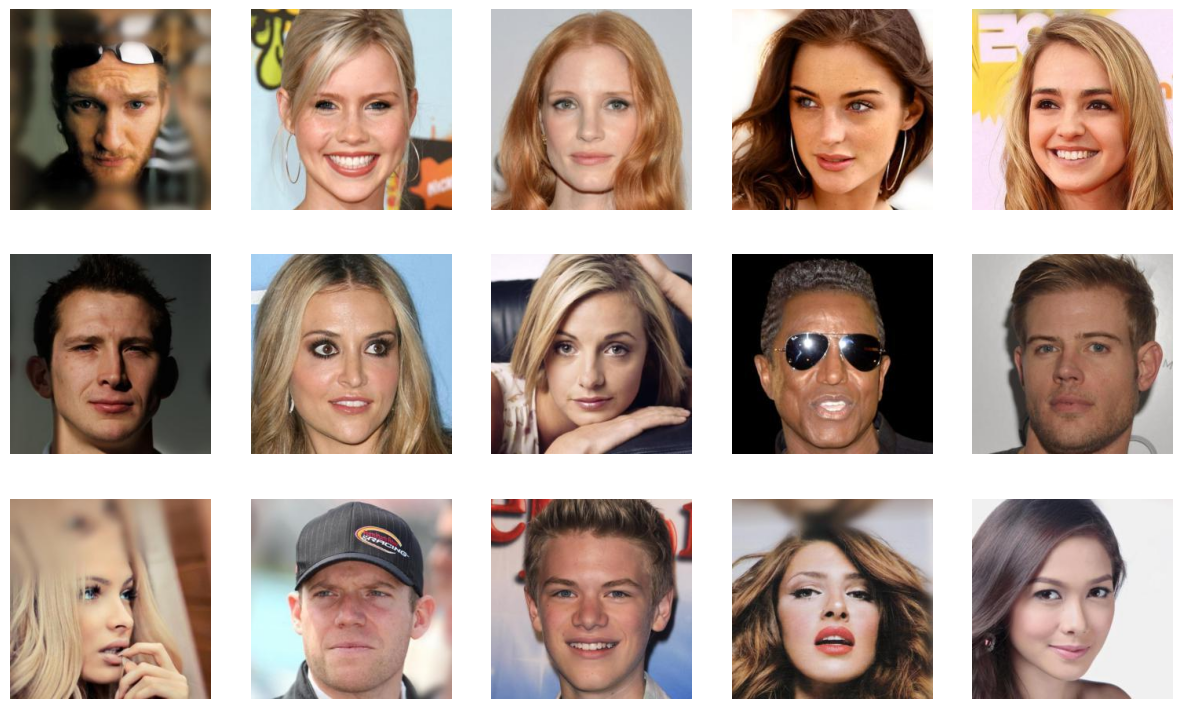

In [4]:
# Plot 15 random images in 3 rows and 5 columns
utils.plot_random_images(dataset_path='human_face_generation_split/raw/train', num_images=15, rows=3, cols=5)

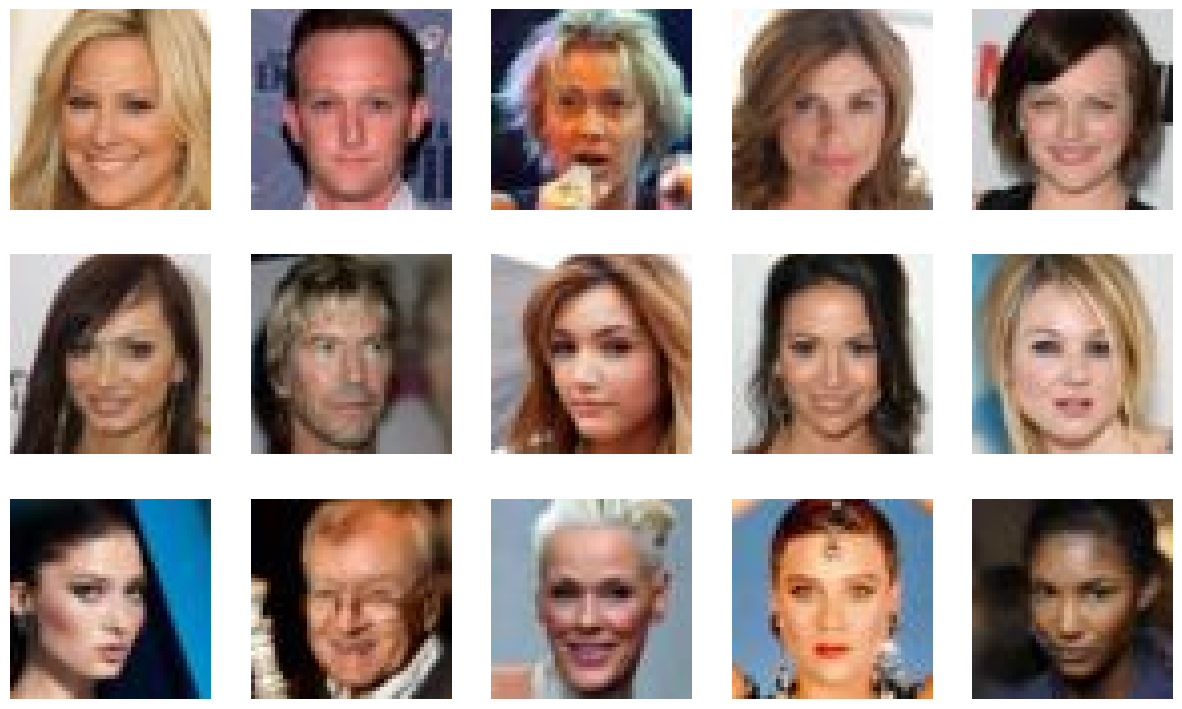

(50, 50)


In [23]:
# Prepoccessing 
preprocess = transforms.Compose([
    transforms.Resize((50, 50)),  # Resize to a specific size if needed tried 200x200 was too big
    transforms.ToTensor(),          # Convert to tensor and normalize
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
preprocessed_output_dir = './human_face_generation_split/preprocessed'
os.makedirs(preprocessed_output_dir, exist_ok=True)
if True:#not os.path.exists(preprocessed_output_dir):#
# Save preprocessed training images

    utils.save_images(ds['train'], 'train', preprocessed_output_dir,preprocess=preprocess)
    utils.plot_random_images(os.path.join(preprocessed_output_dir, 'train'), num_images=15, rows=3, cols=5)
    img = Image.open("human_face_generation_split/preprocessed/train/image_2110.png")
    print(img.size)


In [24]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, img_size=50, flatten=False):
        """
        Args:
            image_folder (str): Path to the folder containing images.
            img_size (int): Size to which each image is resized.
            flatten (bool): Whether to flatten the image into a 1D array.
        """
        self.image_folder = image_folder
        self.img_size = img_size
        self.flatten = flatten
        self.images = os.listdir(image_folder)
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),  # Resize images to img_size x img_size
            transforms.ToTensor()                    # Convert images to PyTorch tensors
        ])

    def __getitem__(self, idx):
        image_file = self.images[idx]
        image = Image.open(os.path.join(self.image_folder, image_file))
        image = self.transform(image)

        if self.flatten:
            image = np.array(image).reshape(-1,50*50) # Flatten the image into a 1D array

        return image

    def __len__(self):
        return len(self.images)
    
dataset_preprocessed = ImageDataset("human_face_generation_split/preprocessed/train")
dataset_preprocessed_lin = ImageDataset("human_face_generation_split/preprocessed/train",flatten=True)

dataset_val = ImageDataset("human_face_generation_split/raw/validation")
dataset_val_lin  = ImageDataset("human_face_generation_split/raw/validation",flatten=True)
dataset_test = ImageDataset("human_face_generation_split/raw/test")
show_dataset = ImageDataset("human_face_generation_split/show_imgs/train")
show_dataset_lin = ImageDataset("human_face_generation_split/show_imgs/train",flatten=True)

train_data = torch.utils.data.DataLoader(dataset_preprocessed,batch_size=32,shuffle=True)
train_data_lin = torch.utils.data.DataLoader(dataset_preprocessed_lin,batch_size=32,shuffle=True)
val_data_lin = torch.utils.data.DataLoader(dataset_val_lin)
val_data = torch.utils.data.DataLoader(dataset_val)
test_data = torch.utils.data.DataLoader(dataset_test)
show_data =torch.utils.data.DataLoader(show_dataset)
show_data_lin =torch.utils.data.DataLoader(show_dataset_lin)

# Linear Autoencoder

This autoencoder consists of linear layers with ReLU activation functions, designed to compress and reconstruct 50x50 pixel images. The model architecture includes three fully connected layers in both the encoder and decoder, with hidden layers of size 512. Xavier initialization is applied to the weights to ensure a good starting point for training. This initialization helps improve convergence and performance by maintaining the variance of the weights across layers.


In [25]:
class Autoencoder_linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.size_hidden_layers = 512 
        self.encoder = nn.Sequential(
            nn.Linear(2500, 2048),  # Assuming 50x50 RGB images
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.size_hidden_layers),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.size_hidden_layers, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2500),  # Output size to match original flattened image
            nn.Sigmoid(),  # Optionally use sigmoid to ensure output is in range [0, 1]
        )        
        # Apply weight initialization
        self.apply(self.init_weights)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        # Flatten input
        #x = x.view(x.size(0), -1)  # Flatten input to shape (batch_size, 50*50*3)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [26]:
# Example usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# For Linear Autoencoder
linear_auto = Autoencoder_linear()
utils.train_autoencoder(linear_auto, train_data_lin, val_data_lin, device, epochs=101, lr=1e-4, ckpt_dir="human_face_generation_split", arch_name="lin", loss_fn="mse")


Epoch 1/101: 100%|██████████| 75/75 [00:02<00:00, 34.49batch/s, train_loss=0.0562]


Epoch 1/101 : train_loss = 0.0528, val_loss = 0.0353


Epoch 2/101: 100%|██████████| 75/75 [00:02<00:00, 33.82batch/s, train_loss=0.0329]


Epoch 2/101 : train_loss = 0.0309, val_loss = 0.0284


Epoch 3/101: 100%|██████████| 75/75 [00:02<00:00, 34.02batch/s, train_loss=0.0283]


Epoch 3/101 : train_loss = 0.0265, val_loss = 0.0268


Epoch 4/101: 100%|██████████| 75/75 [00:02<00:00, 34.35batch/s, train_loss=0.0253]


Epoch 4/101 : train_loss = 0.0237, val_loss = 0.0225


Epoch 5/101: 100%|██████████| 75/75 [00:02<00:00, 35.49batch/s, train_loss=0.0228]


Epoch 5/101 : train_loss = 0.0214, val_loss = 0.0204


Epoch 6/101: 100%|██████████| 75/75 [00:02<00:00, 35.00batch/s, train_loss=0.0218]


Epoch 6/101 : train_loss = 0.0205, val_loss = 0.0196


Epoch 7/101: 100%|██████████| 75/75 [00:02<00:00, 35.82batch/s, train_loss=0.0193]


Epoch 7/101 : train_loss = 0.0181, val_loss = 0.0177


Epoch 8/101: 100%|██████████| 75/75 [00:02<00:00, 36.03batch/s, train_loss=0.0185]


Epoch 8/101 : train_loss = 0.0174, val_loss = 0.0171


Epoch 9/101: 100%|██████████| 75/75 [00:02<00:00, 36.84batch/s, train_loss=0.0172]


Epoch 9/101 : train_loss = 0.0162, val_loss = 0.0161


Epoch 10/101: 100%|██████████| 75/75 [00:02<00:00, 36.66batch/s, train_loss=0.0171]


Epoch 10/101 : train_loss = 0.0161, val_loss = 0.0174


Epoch 11/101: 100%|██████████| 75/75 [00:02<00:00, 36.97batch/s, train_loss=0.0157]


Epoch 11/101 : train_loss = 0.0147, val_loss = 0.0147


Epoch 12/101: 100%|██████████| 75/75 [00:02<00:00, 36.80batch/s, train_loss=0.0148]


Epoch 12/101 : train_loss = 0.0139, val_loss = 0.0139


Epoch 13/101: 100%|██████████| 75/75 [00:02<00:00, 36.57batch/s, train_loss=0.0141]


Epoch 13/101 : train_loss = 0.0132, val_loss = 0.0151


Epoch 14/101: 100%|██████████| 75/75 [00:02<00:00, 36.24batch/s, train_loss=0.0139]


Epoch 14/101 : train_loss = 0.0130, val_loss = 0.0129


Epoch 15/101: 100%|██████████| 75/75 [00:02<00:00, 36.85batch/s, train_loss=0.0134]


Epoch 15/101 : train_loss = 0.0126, val_loss = 0.0124


Epoch 16/101: 100%|██████████| 75/75 [00:02<00:00, 37.21batch/s, train_loss=0.0128]


Epoch 16/101 : train_loss = 0.0120, val_loss = 0.0120


Epoch 17/101: 100%|██████████| 75/75 [00:02<00:00, 36.56batch/s, train_loss=0.0123]


Epoch 17/101 : train_loss = 0.0115, val_loss = 0.0115


Epoch 18/101: 100%|██████████| 75/75 [00:02<00:00, 36.71batch/s, train_loss=0.0119]


Epoch 18/101 : train_loss = 0.0112, val_loss = 0.0121


Epoch 19/101: 100%|██████████| 75/75 [00:02<00:00, 35.80batch/s, train_loss=0.012] 


Epoch 19/101 : train_loss = 0.0112, val_loss = 0.0108


Epoch 20/101: 100%|██████████| 75/75 [00:02<00:00, 35.96batch/s, train_loss=0.0114]


Epoch 20/101 : train_loss = 0.0107, val_loss = 0.0106


Epoch 21/101: 100%|██████████| 75/75 [00:02<00:00, 36.81batch/s, train_loss=0.0111]


Epoch 21/101 : train_loss = 0.0104, val_loss = 0.0103


Epoch 22/101: 100%|██████████| 75/75 [00:02<00:00, 36.00batch/s, train_loss=0.0111] 


Epoch 22/101 : train_loss = 0.0104, val_loss = 0.0107


Epoch 23/101: 100%|██████████| 75/75 [00:02<00:00, 30.65batch/s, train_loss=0.0107] 


Epoch 23/101 : train_loss = 0.0100, val_loss = 0.0102


Epoch 24/101: 100%|██████████| 75/75 [00:02<00:00, 29.51batch/s, train_loss=0.0105] 


Epoch 24/101 : train_loss = 0.0098, val_loss = 0.0101


Epoch 25/101: 100%|██████████| 75/75 [00:02<00:00, 32.04batch/s, train_loss=0.0102] 


Epoch 25/101 : train_loss = 0.0096, val_loss = 0.0097


Epoch 26/101: 100%|██████████| 75/75 [00:02<00:00, 30.98batch/s, train_loss=0.0102] 


Epoch 26/101 : train_loss = 0.0095, val_loss = 0.0094


Epoch 27/101: 100%|██████████| 75/75 [00:02<00:00, 30.66batch/s, train_loss=0.00973]


Epoch 27/101 : train_loss = 0.0091, val_loss = 0.0092


Epoch 28/101: 100%|██████████| 75/75 [00:02<00:00, 30.89batch/s, train_loss=0.0096] 


Epoch 28/101 : train_loss = 0.0090, val_loss = 0.0089


Epoch 29/101: 100%|██████████| 75/75 [00:02<00:00, 30.25batch/s, train_loss=0.00945]


Epoch 29/101 : train_loss = 0.0089, val_loss = 0.0087


Epoch 30/101: 100%|██████████| 75/75 [00:02<00:00, 30.22batch/s, train_loss=0.00912]


Epoch 30/101 : train_loss = 0.0086, val_loss = 0.0088


Epoch 31/101: 100%|██████████| 75/75 [00:02<00:00, 29.27batch/s, train_loss=0.00948]


Epoch 31/101 : train_loss = 0.0089, val_loss = 0.0087


Epoch 32/101: 100%|██████████| 75/75 [00:02<00:00, 30.20batch/s, train_loss=0.00924]


Epoch 32/101 : train_loss = 0.0087, val_loss = 0.0085


Epoch 33/101: 100%|██████████| 75/75 [00:02<00:00, 31.36batch/s, train_loss=0.00885]


Epoch 33/101 : train_loss = 0.0083, val_loss = 0.0085


Epoch 34/101: 100%|██████████| 75/75 [00:02<00:00, 31.58batch/s, train_loss=0.00871]


Epoch 34/101 : train_loss = 0.0082, val_loss = 0.0082


Epoch 35/101: 100%|██████████| 75/75 [00:02<00:00, 29.69batch/s, train_loss=0.00886]


Epoch 35/101 : train_loss = 0.0083, val_loss = 0.0082


Epoch 36/101: 100%|██████████| 75/75 [00:02<00:00, 29.30batch/s, train_loss=0.00837]


Epoch 36/101 : train_loss = 0.0079, val_loss = 0.0079


Epoch 37/101: 100%|██████████| 75/75 [00:02<00:00, 31.66batch/s, train_loss=0.00828]


Epoch 37/101 : train_loss = 0.0078, val_loss = 0.0076


Epoch 38/101: 100%|██████████| 75/75 [00:02<00:00, 28.90batch/s, train_loss=0.00814]


Epoch 38/101 : train_loss = 0.0076, val_loss = 0.0075


Epoch 39/101: 100%|██████████| 75/75 [00:02<00:00, 30.64batch/s, train_loss=0.00787]


Epoch 39/101 : train_loss = 0.0074, val_loss = 0.0075


Epoch 40/101: 100%|██████████| 75/75 [00:02<00:00, 30.51batch/s, train_loss=0.00782]


Epoch 40/101 : train_loss = 0.0073, val_loss = 0.0073


Epoch 41/101: 100%|██████████| 75/75 [00:02<00:00, 29.29batch/s, train_loss=0.00795]


Epoch 41/101 : train_loss = 0.0075, val_loss = 0.0072


Epoch 42/101: 100%|██████████| 75/75 [00:02<00:00, 28.36batch/s, train_loss=0.00785]


Epoch 42/101 : train_loss = 0.0074, val_loss = 0.0091


Epoch 43/101: 100%|██████████| 75/75 [00:02<00:00, 30.65batch/s, train_loss=0.00789]


Epoch 43/101 : train_loss = 0.0074, val_loss = 0.0071


Epoch 44/101: 100%|██████████| 75/75 [00:02<00:00, 29.59batch/s, train_loss=0.00742]


Epoch 44/101 : train_loss = 0.0070, val_loss = 0.0071


Epoch 45/101: 100%|██████████| 75/75 [00:02<00:00, 30.29batch/s, train_loss=0.00744]


Epoch 45/101 : train_loss = 0.0070, val_loss = 0.0071


Epoch 46/101: 100%|██████████| 75/75 [00:02<00:00, 30.33batch/s, train_loss=0.00738]


Epoch 46/101 : train_loss = 0.0069, val_loss = 0.0068


Epoch 47/101: 100%|██████████| 75/75 [00:02<00:00, 29.45batch/s, train_loss=0.00723]


Epoch 47/101 : train_loss = 0.0068, val_loss = 0.0069


Epoch 48/101: 100%|██████████| 75/75 [00:02<00:00, 30.86batch/s, train_loss=0.00753]


Epoch 48/101 : train_loss = 0.0071, val_loss = 0.0068


Epoch 49/101: 100%|██████████| 75/75 [00:02<00:00, 31.65batch/s, train_loss=0.00713]


Epoch 49/101 : train_loss = 0.0067, val_loss = 0.0066


Epoch 50/101: 100%|██████████| 75/75 [00:02<00:00, 29.50batch/s, train_loss=0.00698]


Epoch 50/101 : train_loss = 0.0065, val_loss = 0.0066


Epoch 51/101: 100%|██████████| 75/75 [00:02<00:00, 30.22batch/s, train_loss=0.00738]


Epoch 51/101 : train_loss = 0.0069, val_loss = 0.0068


Epoch 52/101: 100%|██████████| 75/75 [00:02<00:00, 31.20batch/s, train_loss=0.00684]


Epoch 52/101 : train_loss = 0.0064, val_loss = 0.0068


Epoch 53/101: 100%|██████████| 75/75 [00:02<00:00, 31.62batch/s, train_loss=0.007]  


Epoch 53/101 : train_loss = 0.0066, val_loss = 0.0066


Epoch 54/101: 100%|██████████| 75/75 [00:02<00:00, 26.22batch/s, train_loss=0.00694]


Epoch 54/101 : train_loss = 0.0065, val_loss = 0.0063


Epoch 55/101: 100%|██████████| 75/75 [00:02<00:00, 29.71batch/s, train_loss=0.00654]


Epoch 55/101 : train_loss = 0.0061, val_loss = 0.0063


Epoch 56/101: 100%|██████████| 75/75 [00:02<00:00, 30.56batch/s, train_loss=0.00653]


Epoch 56/101 : train_loss = 0.0061, val_loss = 0.0065


Epoch 57/101: 100%|██████████| 75/75 [00:02<00:00, 31.01batch/s, train_loss=0.00649]


Epoch 57/101 : train_loss = 0.0061, val_loss = 0.0062


Epoch 58/101: 100%|██████████| 75/75 [00:02<00:00, 28.77batch/s, train_loss=0.0064] 


Epoch 58/101 : train_loss = 0.0060, val_loss = 0.0064


Epoch 59/101: 100%|██████████| 75/75 [00:02<00:00, 30.06batch/s, train_loss=0.00666]


Epoch 59/101 : train_loss = 0.0062, val_loss = 0.0060


Epoch 60/101: 100%|██████████| 75/75 [00:02<00:00, 30.62batch/s, train_loss=0.00667]


Epoch 60/101 : train_loss = 0.0063, val_loss = 0.0064


Epoch 61/101: 100%|██████████| 75/75 [00:02<00:00, 28.64batch/s, train_loss=0.00647]


Epoch 61/101 : train_loss = 0.0061, val_loss = 0.0059


Epoch 62/101: 100%|██████████| 75/75 [00:02<00:00, 29.92batch/s, train_loss=0.00649]


Epoch 62/101 : train_loss = 0.0061, val_loss = 0.0061


Epoch 63/101: 100%|██████████| 75/75 [00:02<00:00, 30.05batch/s, train_loss=0.0062] 


Epoch 63/101 : train_loss = 0.0058, val_loss = 0.0059


Epoch 64/101: 100%|██████████| 75/75 [00:02<00:00, 31.05batch/s, train_loss=0.00612]


Epoch 64/101 : train_loss = 0.0057, val_loss = 0.0057


Epoch 65/101: 100%|██████████| 75/75 [00:02<00:00, 30.51batch/s, train_loss=0.0059] 


Epoch 65/101 : train_loss = 0.0055, val_loss = 0.0056


Epoch 66/101: 100%|██████████| 75/75 [00:02<00:00, 31.24batch/s, train_loss=0.006]  


Epoch 66/101 : train_loss = 0.0056, val_loss = 0.0058


Epoch 67/101: 100%|██████████| 75/75 [00:02<00:00, 31.53batch/s, train_loss=0.00594]


Epoch 67/101 : train_loss = 0.0056, val_loss = 0.0056


Epoch 68/101: 100%|██████████| 75/75 [00:02<00:00, 31.17batch/s, train_loss=0.00595]


Epoch 68/101 : train_loss = 0.0056, val_loss = 0.0055


Epoch 69/101: 100%|██████████| 75/75 [00:02<00:00, 31.15batch/s, train_loss=0.00642]


Epoch 69/101 : train_loss = 0.0060, val_loss = 0.0059


Epoch 70/101: 100%|██████████| 75/75 [00:02<00:00, 31.89batch/s, train_loss=0.00607]


Epoch 70/101 : train_loss = 0.0057, val_loss = 0.0056


Epoch 71/101: 100%|██████████| 75/75 [00:02<00:00, 30.56batch/s, train_loss=0.00572]


Epoch 71/101 : train_loss = 0.0054, val_loss = 0.0054


Epoch 72/101: 100%|██████████| 75/75 [00:02<00:00, 31.42batch/s, train_loss=0.00562]


Epoch 72/101 : train_loss = 0.0053, val_loss = 0.0053


Epoch 73/101: 100%|██████████| 75/75 [00:02<00:00, 29.79batch/s, train_loss=0.00568]


Epoch 73/101 : train_loss = 0.0053, val_loss = 0.0067


Epoch 74/101: 100%|██████████| 75/75 [00:02<00:00, 30.64batch/s, train_loss=0.00607]


Epoch 74/101 : train_loss = 0.0057, val_loss = 0.0054


Epoch 75/101: 100%|██████████| 75/75 [00:02<00:00, 30.79batch/s, train_loss=0.00558]


Epoch 75/101 : train_loss = 0.0052, val_loss = 0.0054


Epoch 76/101: 100%|██████████| 75/75 [00:02<00:00, 31.31batch/s, train_loss=0.00554]


Epoch 76/101 : train_loss = 0.0052, val_loss = 0.0053


Epoch 77/101: 100%|██████████| 75/75 [00:02<00:00, 29.78batch/s, train_loss=0.00542]


Epoch 77/101 : train_loss = 0.0051, val_loss = 0.0053


Epoch 78/101: 100%|██████████| 75/75 [00:02<00:00, 31.17batch/s, train_loss=0.00563]


Epoch 78/101 : train_loss = 0.0053, val_loss = 0.0068


Epoch 79/101: 100%|██████████| 75/75 [00:02<00:00, 31.66batch/s, train_loss=0.00568]


Epoch 79/101 : train_loss = 0.0053, val_loss = 0.0051


Epoch 80/101: 100%|██████████| 75/75 [00:02<00:00, 29.99batch/s, train_loss=0.00541]


Epoch 80/101 : train_loss = 0.0051, val_loss = 0.0051


Epoch 81/101: 100%|██████████| 75/75 [00:02<00:00, 30.49batch/s, train_loss=0.00531]


Epoch 81/101 : train_loss = 0.0050, val_loss = 0.0052


Epoch 82/101: 100%|██████████| 75/75 [00:02<00:00, 30.59batch/s, train_loss=0.00563]


Epoch 82/101 : train_loss = 0.0053, val_loss = 0.0053


Epoch 83/101: 100%|██████████| 75/75 [00:02<00:00, 31.96batch/s, train_loss=0.00537]


Epoch 83/101 : train_loss = 0.0050, val_loss = 0.0050


Epoch 84/101: 100%|██████████| 75/75 [00:02<00:00, 30.24batch/s, train_loss=0.00521]


Epoch 84/101 : train_loss = 0.0049, val_loss = 0.0049


Epoch 85/101: 100%|██████████| 75/75 [00:02<00:00, 31.91batch/s, train_loss=0.00532]


Epoch 85/101 : train_loss = 0.0050, val_loss = 0.0050


Epoch 86/101: 100%|██████████| 75/75 [00:02<00:00, 29.72batch/s, train_loss=0.00528]


Epoch 86/101 : train_loss = 0.0050, val_loss = 0.0049


Epoch 87/101: 100%|██████████| 75/75 [00:02<00:00, 28.47batch/s, train_loss=0.00512]


Epoch 87/101 : train_loss = 0.0048, val_loss = 0.0048


Epoch 88/101: 100%|██████████| 75/75 [00:02<00:00, 29.50batch/s, train_loss=0.00508]


Epoch 88/101 : train_loss = 0.0048, val_loss = 0.0049


Epoch 89/101: 100%|██████████| 75/75 [00:02<00:00, 30.60batch/s, train_loss=0.00549]


Epoch 89/101 : train_loss = 0.0051, val_loss = 0.0048


Epoch 90/101: 100%|██████████| 75/75 [00:02<00:00, 30.28batch/s, train_loss=0.00516]


Epoch 90/101 : train_loss = 0.0048, val_loss = 0.0053


Epoch 91/101: 100%|██████████| 75/75 [00:02<00:00, 30.66batch/s, train_loss=0.0053] 


Epoch 91/101 : train_loss = 0.0050, val_loss = 0.0047


Epoch 92/101: 100%|██████████| 75/75 [00:02<00:00, 31.78batch/s, train_loss=0.00502]


Epoch 92/101 : train_loss = 0.0047, val_loss = 0.0048


Epoch 93/101: 100%|██████████| 75/75 [00:02<00:00, 31.34batch/s, train_loss=0.00491]


Epoch 93/101 : train_loss = 0.0046, val_loss = 0.0048


Epoch 94/101: 100%|██████████| 75/75 [00:02<00:00, 30.92batch/s, train_loss=0.00491]


Epoch 94/101 : train_loss = 0.0046, val_loss = 0.0047


Epoch 95/101: 100%|██████████| 75/75 [00:02<00:00, 31.49batch/s, train_loss=0.00494]


Epoch 95/101 : train_loss = 0.0046, val_loss = 0.0049


Epoch 96/101: 100%|██████████| 75/75 [00:02<00:00, 30.97batch/s, train_loss=0.00485]


Epoch 96/101 : train_loss = 0.0045, val_loss = 0.0047


Epoch 97/101: 100%|██████████| 75/75 [00:02<00:00, 29.91batch/s, train_loss=0.00505]


Epoch 97/101 : train_loss = 0.0047, val_loss = 0.0050


Epoch 98/101: 100%|██████████| 75/75 [00:02<00:00, 29.99batch/s, train_loss=0.005]  


Epoch 98/101 : train_loss = 0.0047, val_loss = 0.0049


Epoch 99/101: 100%|██████████| 75/75 [00:02<00:00, 30.98batch/s, train_loss=0.00488]


Epoch 99/101 : train_loss = 0.0046, val_loss = 0.0047


Epoch 100/101: 100%|██████████| 75/75 [00:02<00:00, 30.36batch/s, train_loss=0.00488]


Epoch 100/101 : train_loss = 0.0046, val_loss = 0.0045


Epoch 101/101: 100%|██████████| 75/75 [00:02<00:00, 30.72batch/s, train_loss=0.00465]


Epoch 101/101 : train_loss = 0.0044, val_loss = 0.0045


cuda:0
Reconstructed Image 0 shape: (3, 2500)
Reconstructed Image 1 shape: (3, 2500)
Reconstructed Image 2 shape: (3, 2500)
Reconstructed Image 3 shape: (3, 2500)
Reconstructed Image 4 shape: (3, 2500)


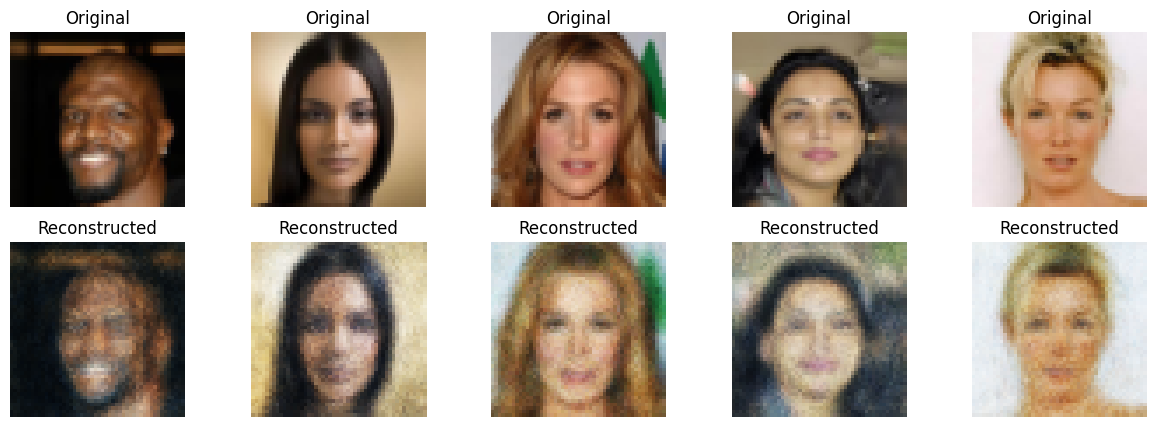

In [27]:
linear_auto = Autoencoder_linear()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#optimizer = torch.optim.Adam(linear_auto.parameters(), lr=1e-4)
checkpoint = torch.load("human_face_generation_split/20240904_173106_lin/checkpoint_epoch_101.pt", weights_only=True)
linear_auto.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['train_loss']
#linear_auto.eval()
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Assuming you want to plot 5 images
utils.plot_original_and_reconstructed(linear_auto, show_data_lin, num_images=5,device=device)


In [28]:
class Autoencoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 2 ,stride = 2),
            nn.ReLU(),# possibly add max pooling
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 2, stride = 2),
            nn.ReLU()
        )    
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 64,out_channels=32,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 32 , out_channels = 3 ,kernel_size=2,stride =2),
            nn.Sigmoid()
        )
    def forward(self,x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return encoded, decoded

In [29]:

conv_auto = Autoencoder_conv()  # Assuming you have this class defined
utils.train_autoencoder(conv_auto, train_data, val_data, device, epochs=101, lr=1e-4, ckpt_dir="human_face_generation_split", arch_name="conv", loss_fn="mse")


Epoch 1/101: 100%|██████████| 75/75 [00:01<00:00, 58.72batch/s, train_loss=0.0948]


Epoch 1/101 : train_loss = 0.0889, val_loss = 0.0872


Epoch 2/101: 100%|██████████| 75/75 [00:01<00:00, 66.54batch/s, train_loss=0.0857]


Epoch 2/101 : train_loss = 0.0804, val_loss = 0.0723


Epoch 3/101: 100%|██████████| 75/75 [00:01<00:00, 64.50batch/s, train_loss=0.0614]


Epoch 3/101 : train_loss = 0.0576, val_loss = 0.0437


Epoch 4/101: 100%|██████████| 75/75 [00:01<00:00, 60.78batch/s, train_loss=0.0351]


Epoch 4/101 : train_loss = 0.0330, val_loss = 0.0256


Epoch 5/101: 100%|██████████| 75/75 [00:01<00:00, 62.34batch/s, train_loss=0.0223]


Epoch 5/101 : train_loss = 0.0209, val_loss = 0.0180


Epoch 6/101: 100%|██████████| 75/75 [00:01<00:00, 44.92batch/s, train_loss=0.0168]


Epoch 6/101 : train_loss = 0.0158, val_loss = 0.0146


Epoch 7/101: 100%|██████████| 75/75 [00:01<00:00, 48.92batch/s, train_loss=0.0142]


Epoch 7/101 : train_loss = 0.0133, val_loss = 0.0128


Epoch 8/101: 100%|██████████| 75/75 [00:01<00:00, 55.27batch/s, train_loss=0.0126]


Epoch 8/101 : train_loss = 0.0119, val_loss = 0.0116


Epoch 9/101: 100%|██████████| 75/75 [00:01<00:00, 61.01batch/s, train_loss=0.0115]


Epoch 9/101 : train_loss = 0.0108, val_loss = 0.0107


Epoch 10/101: 100%|██████████| 75/75 [00:01<00:00, 61.37batch/s, train_loss=0.0106] 


Epoch 10/101 : train_loss = 0.0100, val_loss = 0.0100


Epoch 11/101: 100%|██████████| 75/75 [00:01<00:00, 56.10batch/s, train_loss=0.00993]


Epoch 11/101 : train_loss = 0.0093, val_loss = 0.0093


Epoch 12/101: 100%|██████████| 75/75 [00:01<00:00, 60.03batch/s, train_loss=0.00932]


Epoch 12/101 : train_loss = 0.0087, val_loss = 0.0088


Epoch 13/101: 100%|██████████| 75/75 [00:01<00:00, 66.91batch/s, train_loss=0.00873]


Epoch 13/101 : train_loss = 0.0082, val_loss = 0.0082


Epoch 14/101: 100%|██████████| 75/75 [00:01<00:00, 60.74batch/s, train_loss=0.00822]


Epoch 14/101 : train_loss = 0.0077, val_loss = 0.0077


Epoch 15/101: 100%|██████████| 75/75 [00:01<00:00, 58.73batch/s, train_loss=0.00776]


Epoch 15/101 : train_loss = 0.0073, val_loss = 0.0073


Epoch 16/101: 100%|██████████| 75/75 [00:01<00:00, 64.87batch/s, train_loss=0.00736]


Epoch 16/101 : train_loss = 0.0069, val_loss = 0.0070


Epoch 17/101: 100%|██████████| 75/75 [00:01<00:00, 66.86batch/s, train_loss=0.00699]


Epoch 17/101 : train_loss = 0.0066, val_loss = 0.0066


Epoch 18/101: 100%|██████████| 75/75 [00:01<00:00, 57.92batch/s, train_loss=0.00666]


Epoch 18/101 : train_loss = 0.0062, val_loss = 0.0063


Epoch 19/101: 100%|██████████| 75/75 [00:01<00:00, 62.32batch/s, train_loss=0.00637]


Epoch 19/101 : train_loss = 0.0060, val_loss = 0.0060


Epoch 20/101: 100%|██████████| 75/75 [00:01<00:00, 55.98batch/s, train_loss=0.00611]


Epoch 20/101 : train_loss = 0.0057, val_loss = 0.0058


Epoch 21/101: 100%|██████████| 75/75 [00:01<00:00, 60.40batch/s, train_loss=0.00588]


Epoch 21/101 : train_loss = 0.0055, val_loss = 0.0056


Epoch 22/101: 100%|██████████| 75/75 [00:01<00:00, 56.56batch/s, train_loss=0.00567]


Epoch 22/101 : train_loss = 0.0053, val_loss = 0.0054


Epoch 23/101: 100%|██████████| 75/75 [00:01<00:00, 63.13batch/s, train_loss=0.00547]


Epoch 23/101 : train_loss = 0.0051, val_loss = 0.0052


Epoch 24/101: 100%|██████████| 75/75 [00:01<00:00, 61.31batch/s, train_loss=0.00528]


Epoch 24/101 : train_loss = 0.0050, val_loss = 0.0051


Epoch 25/101: 100%|██████████| 75/75 [00:01<00:00, 55.49batch/s, train_loss=0.00512]


Epoch 25/101 : train_loss = 0.0048, val_loss = 0.0049


Epoch 26/101: 100%|██████████| 75/75 [00:01<00:00, 62.41batch/s, train_loss=0.00497]


Epoch 26/101 : train_loss = 0.0047, val_loss = 0.0048


Epoch 27/101: 100%|██████████| 75/75 [00:01<00:00, 62.51batch/s, train_loss=0.00483]


Epoch 27/101 : train_loss = 0.0045, val_loss = 0.0046


Epoch 28/101: 100%|██████████| 75/75 [00:01<00:00, 60.95batch/s, train_loss=0.0047] 


Epoch 28/101 : train_loss = 0.0044, val_loss = 0.0045


Epoch 29/101: 100%|██████████| 75/75 [00:01<00:00, 62.22batch/s, train_loss=0.00458]


Epoch 29/101 : train_loss = 0.0043, val_loss = 0.0044


Epoch 30/101: 100%|██████████| 75/75 [00:01<00:00, 58.25batch/s, train_loss=0.00446]


Epoch 30/101 : train_loss = 0.0042, val_loss = 0.0043


Epoch 31/101: 100%|██████████| 75/75 [00:01<00:00, 63.74batch/s, train_loss=0.00436]


Epoch 31/101 : train_loss = 0.0041, val_loss = 0.0042


Epoch 32/101: 100%|██████████| 75/75 [00:00<00:00, 88.51batch/s, train_loss=0.00426]


Epoch 32/101 : train_loss = 0.0040, val_loss = 0.0041


Epoch 33/101: 100%|██████████| 75/75 [00:00<00:00, 81.46batch/s, train_loss=0.00417]


Epoch 33/101 : train_loss = 0.0039, val_loss = 0.0040


Epoch 34/101: 100%|██████████| 75/75 [00:01<00:00, 72.77batch/s, train_loss=0.00408]


Epoch 34/101 : train_loss = 0.0038, val_loss = 0.0040


Epoch 35/101: 100%|██████████| 75/75 [00:00<00:00, 75.72batch/s, train_loss=0.004]  


Epoch 35/101 : train_loss = 0.0038, val_loss = 0.0039


Epoch 36/101: 100%|██████████| 75/75 [00:00<00:00, 89.36batch/s, train_loss=0.00392]


Epoch 36/101 : train_loss = 0.0037, val_loss = 0.0038


Epoch 37/101: 100%|██████████| 75/75 [00:00<00:00, 91.35batch/s, train_loss=0.00383]


Epoch 37/101 : train_loss = 0.0036, val_loss = 0.0037


Epoch 38/101: 100%|██████████| 75/75 [00:00<00:00, 93.37batch/s, train_loss=0.00376]


Epoch 38/101 : train_loss = 0.0035, val_loss = 0.0037


Epoch 39/101: 100%|██████████| 75/75 [00:00<00:00, 80.33batch/s, train_loss=0.00369]


Epoch 39/101 : train_loss = 0.0035, val_loss = 0.0036


Epoch 40/101: 100%|██████████| 75/75 [00:00<00:00, 91.08batch/s, train_loss=0.00363]


Epoch 40/101 : train_loss = 0.0034, val_loss = 0.0035


Epoch 41/101: 100%|██████████| 75/75 [00:00<00:00, 90.55batch/s, train_loss=0.00356]


Epoch 41/101 : train_loss = 0.0033, val_loss = 0.0035


Epoch 42/101: 100%|██████████| 75/75 [00:00<00:00, 92.05batch/s, train_loss=0.00351]


Epoch 42/101 : train_loss = 0.0033, val_loss = 0.0034


Epoch 43/101: 100%|██████████| 75/75 [00:00<00:00, 87.47batch/s, train_loss=0.00345]


Epoch 43/101 : train_loss = 0.0032, val_loss = 0.0034


Epoch 44/101: 100%|██████████| 75/75 [00:00<00:00, 89.68batch/s, train_loss=0.0034] 


Epoch 44/101 : train_loss = 0.0032, val_loss = 0.0033


Epoch 45/101: 100%|██████████| 75/75 [00:00<00:00, 75.17batch/s, train_loss=0.00335]


Epoch 45/101 : train_loss = 0.0031, val_loss = 0.0033


Epoch 46/101: 100%|██████████| 75/75 [00:00<00:00, 84.43batch/s, train_loss=0.00331]


Epoch 46/101 : train_loss = 0.0031, val_loss = 0.0032


Epoch 47/101: 100%|██████████| 75/75 [00:00<00:00, 95.17batch/s, train_loss=0.00326]


Epoch 47/101 : train_loss = 0.0031, val_loss = 0.0032


Epoch 48/101: 100%|██████████| 75/75 [00:00<00:00, 84.28batch/s, train_loss=0.00322]


Epoch 48/101 : train_loss = 0.0030, val_loss = 0.0032


Epoch 49/101: 100%|██████████| 75/75 [00:00<00:00, 82.65batch/s, train_loss=0.00318]


Epoch 49/101 : train_loss = 0.0030, val_loss = 0.0031


Epoch 50/101: 100%|██████████| 75/75 [00:00<00:00, 89.66batch/s, train_loss=0.00315]


Epoch 50/101 : train_loss = 0.0030, val_loss = 0.0031


Epoch 51/101: 100%|██████████| 75/75 [00:00<00:00, 85.07batch/s, train_loss=0.00311]


Epoch 51/101 : train_loss = 0.0029, val_loss = 0.0031


Epoch 52/101: 100%|██████████| 75/75 [00:00<00:00, 78.20batch/s, train_loss=0.00307]


Epoch 52/101 : train_loss = 0.0029, val_loss = 0.0030


Epoch 53/101: 100%|██████████| 75/75 [00:00<00:00, 87.53batch/s, train_loss=0.00304]


Epoch 53/101 : train_loss = 0.0029, val_loss = 0.0030


Epoch 54/101: 100%|██████████| 75/75 [00:00<00:00, 80.13batch/s, train_loss=0.00301]


Epoch 54/101 : train_loss = 0.0028, val_loss = 0.0030


Epoch 55/101: 100%|██████████| 75/75 [00:00<00:00, 83.07batch/s, train_loss=0.00297]


Epoch 55/101 : train_loss = 0.0028, val_loss = 0.0029


Epoch 56/101: 100%|██████████| 75/75 [00:00<00:00, 87.60batch/s, train_loss=0.00294]


Epoch 56/101 : train_loss = 0.0028, val_loss = 0.0029


Epoch 57/101: 100%|██████████| 75/75 [00:00<00:00, 87.73batch/s, train_loss=0.00292]


Epoch 57/101 : train_loss = 0.0027, val_loss = 0.0029


Epoch 58/101: 100%|██████████| 75/75 [00:00<00:00, 77.19batch/s, train_loss=0.00288]


Epoch 58/101 : train_loss = 0.0027, val_loss = 0.0028


Epoch 59/101: 100%|██████████| 75/75 [00:00<00:00, 82.44batch/s, train_loss=0.00286]


Epoch 59/101 : train_loss = 0.0027, val_loss = 0.0028


Epoch 60/101: 100%|██████████| 75/75 [00:00<00:00, 80.67batch/s, train_loss=0.00283]


Epoch 60/101 : train_loss = 0.0027, val_loss = 0.0028


Epoch 61/101: 100%|██████████| 75/75 [00:00<00:00, 81.23batch/s, train_loss=0.0028] 


Epoch 61/101 : train_loss = 0.0026, val_loss = 0.0028


Epoch 62/101: 100%|██████████| 75/75 [00:01<00:00, 71.12batch/s, train_loss=0.00278]


Epoch 62/101 : train_loss = 0.0026, val_loss = 0.0027


Epoch 63/101: 100%|██████████| 75/75 [00:00<00:00, 78.75batch/s, train_loss=0.00275]


Epoch 63/101 : train_loss = 0.0026, val_loss = 0.0027


Epoch 64/101: 100%|██████████| 75/75 [00:00<00:00, 87.94batch/s, train_loss=0.00272]


Epoch 64/101 : train_loss = 0.0026, val_loss = 0.0027


Epoch 65/101: 100%|██████████| 75/75 [00:00<00:00, 83.05batch/s, train_loss=0.0027] 


Epoch 65/101 : train_loss = 0.0025, val_loss = 0.0027


Epoch 66/101: 100%|██████████| 75/75 [00:00<00:00, 86.53batch/s, train_loss=0.00268]


Epoch 66/101 : train_loss = 0.0025, val_loss = 0.0026


Epoch 67/101: 100%|██████████| 75/75 [00:00<00:00, 89.45batch/s, train_loss=0.00265]


Epoch 67/101 : train_loss = 0.0025, val_loss = 0.0026


Epoch 68/101: 100%|██████████| 75/75 [00:00<00:00, 81.43batch/s, train_loss=0.00263]


Epoch 68/101 : train_loss = 0.0025, val_loss = 0.0026


Epoch 69/101: 100%|██████████| 75/75 [00:00<00:00, 81.70batch/s, train_loss=0.0026] 


Epoch 69/101 : train_loss = 0.0024, val_loss = 0.0026


Epoch 70/101: 100%|██████████| 75/75 [00:01<00:00, 74.18batch/s, train_loss=0.00258]


Epoch 70/101 : train_loss = 0.0024, val_loss = 0.0026


Epoch 71/101: 100%|██████████| 75/75 [00:00<00:00, 83.77batch/s, train_loss=0.00256]


Epoch 71/101 : train_loss = 0.0024, val_loss = 0.0025


Epoch 72/101: 100%|██████████| 75/75 [00:00<00:00, 80.58batch/s, train_loss=0.00253]


Epoch 72/101 : train_loss = 0.0024, val_loss = 0.0025


Epoch 73/101: 100%|██████████| 75/75 [00:00<00:00, 78.48batch/s, train_loss=0.00251]


Epoch 73/101 : train_loss = 0.0024, val_loss = 0.0025


Epoch 74/101: 100%|██████████| 75/75 [00:00<00:00, 78.77batch/s, train_loss=0.00248]


Epoch 74/101 : train_loss = 0.0023, val_loss = 0.0025


Epoch 75/101: 100%|██████████| 75/75 [00:00<00:00, 92.01batch/s, train_loss=0.00246]


Epoch 75/101 : train_loss = 0.0023, val_loss = 0.0024


Epoch 76/101: 100%|██████████| 75/75 [00:00<00:00, 82.46batch/s, train_loss=0.00244]


Epoch 76/101 : train_loss = 0.0023, val_loss = 0.0024


Epoch 77/101: 100%|██████████| 75/75 [00:00<00:00, 86.16batch/s, train_loss=0.00242]


Epoch 77/101 : train_loss = 0.0023, val_loss = 0.0024


Epoch 78/101: 100%|██████████| 75/75 [00:00<00:00, 83.61batch/s, train_loss=0.00239]


Epoch 78/101 : train_loss = 0.0022, val_loss = 0.0024


Epoch 79/101: 100%|██████████| 75/75 [00:00<00:00, 88.71batch/s, train_loss=0.00237]


Epoch 79/101 : train_loss = 0.0022, val_loss = 0.0024


Epoch 80/101: 100%|██████████| 75/75 [00:00<00:00, 85.98batch/s, train_loss=0.00235]


Epoch 80/101 : train_loss = 0.0022, val_loss = 0.0023


Epoch 81/101: 100%|██████████| 75/75 [00:00<00:00, 90.24batch/s, train_loss=0.00233]


Epoch 81/101 : train_loss = 0.0022, val_loss = 0.0023


Epoch 82/101: 100%|██████████| 75/75 [00:00<00:00, 93.97batch/s, train_loss=0.00231]


Epoch 82/101 : train_loss = 0.0022, val_loss = 0.0023


Epoch 83/101: 100%|██████████| 75/75 [00:00<00:00, 93.82batch/s, train_loss=0.00228]


Epoch 83/101 : train_loss = 0.0021, val_loss = 0.0023


Epoch 84/101: 100%|██████████| 75/75 [00:00<00:00, 89.58batch/s, train_loss=0.00226]


Epoch 84/101 : train_loss = 0.0021, val_loss = 0.0023


Epoch 85/101: 100%|██████████| 75/75 [00:00<00:00, 78.13batch/s, train_loss=0.00224]


Epoch 85/101 : train_loss = 0.0021, val_loss = 0.0022


Epoch 86/101: 100%|██████████| 75/75 [00:00<00:00, 83.14batch/s, train_loss=0.00222]


Epoch 86/101 : train_loss = 0.0021, val_loss = 0.0022


Epoch 87/101: 100%|██████████| 75/75 [00:00<00:00, 75.68batch/s, train_loss=0.0022] 


Epoch 87/101 : train_loss = 0.0021, val_loss = 0.0022


Epoch 88/101: 100%|██████████| 75/75 [00:00<00:00, 80.98batch/s, train_loss=0.00218]


Epoch 88/101 : train_loss = 0.0020, val_loss = 0.0022


Epoch 89/101: 100%|██████████| 75/75 [00:00<00:00, 79.12batch/s, train_loss=0.00216]


Epoch 89/101 : train_loss = 0.0020, val_loss = 0.0022


Epoch 90/101: 100%|██████████| 75/75 [00:00<00:00, 88.52batch/s, train_loss=0.00215]


Epoch 90/101 : train_loss = 0.0020, val_loss = 0.0021


Epoch 91/101: 100%|██████████| 75/75 [00:00<00:00, 82.92batch/s, train_loss=0.00213]


Epoch 91/101 : train_loss = 0.0020, val_loss = 0.0021


Epoch 92/101: 100%|██████████| 75/75 [00:00<00:00, 81.94batch/s, train_loss=0.00211]


Epoch 92/101 : train_loss = 0.0020, val_loss = 0.0021


Epoch 93/101: 100%|██████████| 75/75 [00:00<00:00, 85.18batch/s, train_loss=0.00209]


Epoch 93/101 : train_loss = 0.0020, val_loss = 0.0021


Epoch 94/101: 100%|██████████| 75/75 [00:00<00:00, 82.40batch/s, train_loss=0.00207]


Epoch 94/101 : train_loss = 0.0019, val_loss = 0.0021


Epoch 95/101: 100%|██████████| 75/75 [00:00<00:00, 76.84batch/s, train_loss=0.00206]


Epoch 95/101 : train_loss = 0.0019, val_loss = 0.0021


Epoch 96/101: 100%|██████████| 75/75 [00:00<00:00, 90.55batch/s, train_loss=0.00204]


Epoch 96/101 : train_loss = 0.0019, val_loss = 0.0021


Epoch 97/101: 100%|██████████| 75/75 [00:00<00:00, 90.11batch/s, train_loss=0.00203]


Epoch 97/101 : train_loss = 0.0019, val_loss = 0.0020


Epoch 98/101: 100%|██████████| 75/75 [00:00<00:00, 90.57batch/s, train_loss=0.00201]


Epoch 98/101 : train_loss = 0.0019, val_loss = 0.0020


Epoch 99/101: 100%|██████████| 75/75 [00:00<00:00, 89.65batch/s, train_loss=0.00199]


Epoch 99/101 : train_loss = 0.0019, val_loss = 0.0020


Epoch 100/101: 100%|██████████| 75/75 [00:00<00:00, 83.09batch/s, train_loss=0.00198]


Epoch 100/101 : train_loss = 0.0019, val_loss = 0.0020


Epoch 101/101: 100%|██████████| 75/75 [00:00<00:00, 81.62batch/s, train_loss=0.00197]


Epoch 101/101 : train_loss = 0.0018, val_loss = 0.0020


cuda:0
Reconstructed Image 0 shape: (3, 50, 50)
Reconstructed Image 1 shape: (3, 50, 50)
Reconstructed Image 2 shape: (3, 50, 50)
Reconstructed Image 3 shape: (3, 50, 50)
Reconstructed Image 4 shape: (3, 50, 50)


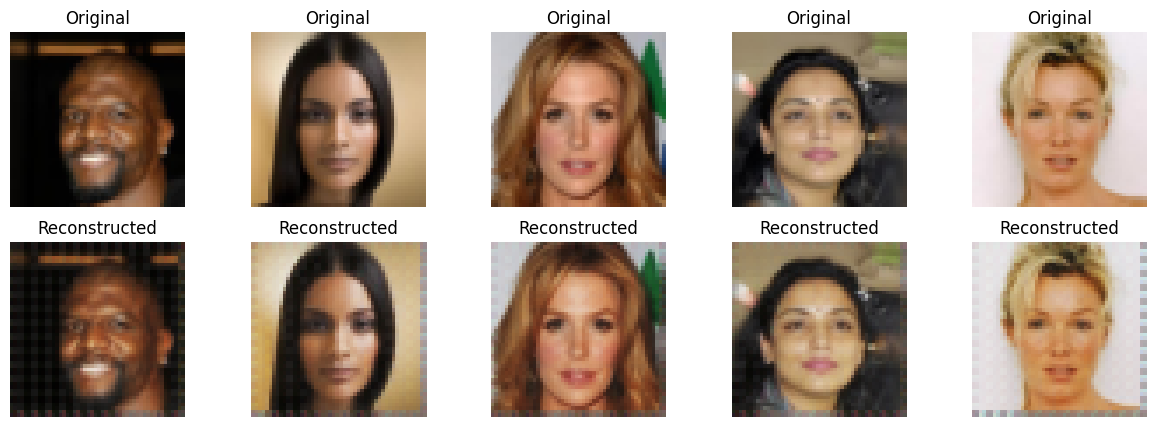

In [30]:
auto_conv = Autoencoder_conv()
optimizer = torch.optim.Adam(auto_conv.parameters(), lr=1e-4)
checkpoint = torch.load("human_face_generation_split/20240904_215342_conv/checkpoint_epoch_101.pt", weights_only=True)
auto_conv.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch torchvision.ckpoint['epoch']
#loss = checkpoint['train_loss']
#linear_auto.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Assuming you want to plot 5 images
utils.plot_original_and_reconstructed(auto_conv, show_data, num_images=5,device=device)

In [43]:
import gc

vae.cpu()
del vae
gc.collect()
torch.cuda.empty_cache()

In [47]:
# VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3 , out_channels = 256, kernel_size = 2 ,stride = 2,bias=False),
           # nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1,inplace=True),# possibly add max pooling
            #nn.Dropout(0.25),
            nn.Conv2d(in_channels = 256,out_channels = 512, kernel_size = 2, stride = 2,bias=False),
            #nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1,inplace=True),# possibly add max pooling
           # nn.Dropout(0.25),
        )    
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 512,out_channels=256,kernel_size=3,stride=2,bias=False),
          #  nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1,inplace=True),# possibly add max pooling
           # nn.Dropout(0.25),
            nn.ConvTranspose2d(in_channels = 256 , out_channels = 3 ,kernel_size=2,stride =2,bias=False),
            nn.Sigmoid()# possibly add max pooling
        )
        
        # latent mean and variance 
   # Latent space
        self.fc1 = nn.Linear(512*12*12, 512)  # Map to latent mean
        self.fc2 = nn.Linear(512*12*12, 512)  # Map to latent logvar
        self.fc3 = nn.Linear(512, 512*12*12)  # Map back from latent space to decoder input
        self.apply(self.init_weights)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.1)
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for the linear layers
        mean = self.fc1(x)
        logvar = self.fc2(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        #std = torch.exp(0.5 * logvar)

        epsilon = torch.randn_like(logvar).to(device)      
        z = mean + logvar*epsilon
        return z


    def decode(self, z):
        z = self.fc3(z)
        z = z.view(z.size(0), 512, 12, 12)  # Reshape to the dimensions expected by the decoder
        x_hat = self.decoder(z)
        return x_hat


    def forward(self, x):
        #x=self.encode(x)
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar
  

In [48]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
   # print(f'Reconstruction Loss: {reproduction_loss.item()}, KL Divergence: {KLD.item()}')

    return reproduction_loss + KLD


In [49]:
# For Variational Autoencoder (VAE)
vae = VAE()  # Assuming you have this class defined
utils.train_autoencoder(vae, train_data, val_data, device, epochs=101, lr=1e-4, 
                        ckpt_dir="human_face_generation_split", arch_name="vae", loss_fn="vae")

Epoch 1/101: 100%|██████████| 75/75 [00:10<00:00,  7.13batch/s, train_loss=1.25e+4]


Epoch 1/101 : train_loss = 11770.5398, val_loss = 226.7855


Epoch 2/101: 100%|██████████| 75/75 [00:10<00:00,  7.17batch/s, train_loss=6.51e+3]


Epoch 2/101 : train_loss = 6104.6383, val_loss = 166.9823


Epoch 3/101: 100%|██████████| 75/75 [00:10<00:00,  7.16batch/s, train_loss=5.05e+3]


Epoch 3/101 : train_loss = 4742.3516, val_loss = 135.3219


Epoch 4/101: 100%|██████████| 75/75 [00:10<00:00,  7.14batch/s, train_loss=4.19e+3]


Epoch 4/101 : train_loss = 3928.8539, val_loss = 114.0458


Epoch 5/101: 100%|██████████| 75/75 [00:10<00:00,  7.09batch/s, train_loss=3.63e+3]


Epoch 5/101 : train_loss = 3406.9073, val_loss = 99.7765


Epoch 6/101: 100%|██████████| 75/75 [00:11<00:00,  6.79batch/s, train_loss=3.19e+3]


Epoch 6/101 : train_loss = 2992.8805, val_loss = 90.5524


Epoch 7/101: 100%|██████████| 75/75 [00:11<00:00,  6.60batch/s, train_loss=2.91e+3]


Epoch 7/101 : train_loss = 2733.2356, val_loss = 85.2204


Epoch 8/101: 100%|██████████| 75/75 [00:11<00:00,  6.59batch/s, train_loss=2.67e+3]


Epoch 8/101 : train_loss = 2507.7437, val_loss = 75.8683


Epoch 9/101: 100%|██████████| 75/75 [00:11<00:00,  6.72batch/s, train_loss=2.47e+3]


Epoch 9/101 : train_loss = 2313.0128, val_loss = 70.7998


Epoch 10/101: 100%|██████████| 75/75 [00:11<00:00,  6.72batch/s, train_loss=2.3e+3] 


Epoch 10/101 : train_loss = 2156.1798, val_loss = 66.5561


Epoch 11/101: 100%|██████████| 75/75 [00:11<00:00,  6.67batch/s, train_loss=2.15e+3]


Epoch 11/101 : train_loss = 2021.2061, val_loss = 62.5580


Epoch 12/101: 100%|██████████| 75/75 [00:11<00:00,  6.77batch/s, train_loss=2.03e+3]


Epoch 12/101 : train_loss = 1908.1865, val_loss = 59.5076


Epoch 13/101: 100%|██████████| 75/75 [00:11<00:00,  6.74batch/s, train_loss=1.95e+3]


Epoch 13/101 : train_loss = 1828.6496, val_loss = 56.8691


Epoch 14/101: 100%|██████████| 75/75 [00:11<00:00,  6.71batch/s, train_loss=1.84e+3]


Epoch 14/101 : train_loss = 1729.7001, val_loss = 54.7735


Epoch 15/101: 100%|██████████| 75/75 [00:11<00:00,  6.72batch/s, train_loss=1.75e+3]


Epoch 15/101 : train_loss = 1643.5731, val_loss = 52.0407


Epoch 16/101: 100%|██████████| 75/75 [00:11<00:00,  6.68batch/s, train_loss=1.67e+3]


Epoch 16/101 : train_loss = 1562.9744, val_loss = 49.8941


Epoch 17/101: 100%|██████████| 75/75 [00:11<00:00,  6.64batch/s, train_loss=1.62e+3]


Epoch 17/101 : train_loss = 1519.1393, val_loss = 48.5717


Epoch 18/101: 100%|██████████| 75/75 [00:11<00:00,  6.67batch/s, train_loss=1.56e+3]


Epoch 18/101 : train_loss = 1463.3038, val_loss = 47.4536


Epoch 19/101: 100%|██████████| 75/75 [00:11<00:00,  6.74batch/s, train_loss=1.48e+3]


Epoch 19/101 : train_loss = 1389.0611, val_loss = 45.0917


Epoch 20/101: 100%|██████████| 75/75 [00:11<00:00,  6.72batch/s, train_loss=1.43e+3]


Epoch 20/101 : train_loss = 1343.4522, val_loss = 43.8883


Epoch 21/101: 100%|██████████| 75/75 [00:11<00:00,  6.78batch/s, train_loss=1.38e+3]


Epoch 21/101 : train_loss = 1297.7617, val_loss = 42.2680


Epoch 22/101: 100%|██████████| 75/75 [00:11<00:00,  6.72batch/s, train_loss=1.33e+3]


Epoch 22/101 : train_loss = 1245.6377, val_loss = 41.8675


Epoch 23/101: 100%|██████████| 75/75 [00:11<00:00,  6.70batch/s, train_loss=1.29e+3]


Epoch 23/101 : train_loss = 1207.9710, val_loss = 40.1305


Epoch 24/101: 100%|██████████| 75/75 [00:11<00:00,  6.75batch/s, train_loss=1.24e+3]


Epoch 24/101 : train_loss = 1167.3506, val_loss = 38.9008


Epoch 25/101: 100%|██████████| 75/75 [00:11<00:00,  6.68batch/s, train_loss=1.22e+3]


Epoch 25/101 : train_loss = 1147.4709, val_loss = 38.2781


Epoch 26/101: 100%|██████████| 75/75 [00:11<00:00,  6.74batch/s, train_loss=1.17e+3]


Epoch 26/101 : train_loss = 1100.3968, val_loss = 36.5411


Epoch 27/101: 100%|██████████| 75/75 [00:11<00:00,  6.70batch/s, train_loss=1.14e+3]


Epoch 27/101 : train_loss = 1065.2989, val_loss = 37.1787


Epoch 28/101: 100%|██████████| 75/75 [00:11<00:00,  6.71batch/s, train_loss=1.16e+3]


Epoch 28/101 : train_loss = 1089.0287, val_loss = 37.4974


Epoch 29/101: 100%|██████████| 75/75 [00:11<00:00,  6.68batch/s, train_loss=1.12e+3]


Epoch 29/101 : train_loss = 1047.1698, val_loss = 34.8825


Epoch 30/101: 100%|██████████| 75/75 [00:11<00:00,  6.65batch/s, train_loss=1.06e+3]


Epoch 30/101 : train_loss = 996.0812, val_loss = 33.9030


Epoch 31/101: 100%|██████████| 75/75 [00:11<00:00,  6.64batch/s, train_loss=1.03e+3]


Epoch 31/101 : train_loss = 964.0331, val_loss = 33.0761


Epoch 32/101: 100%|██████████| 75/75 [00:11<00:00,  6.72batch/s, train_loss=998]


Epoch 32/101 : train_loss = 936.5512, val_loss = 32.5679


Epoch 33/101: 100%|██████████| 75/75 [00:11<00:00,  6.76batch/s, train_loss=1e+3]


Epoch 33/101 : train_loss = 942.2494, val_loss = 32.7815


Epoch 34/101: 100%|██████████| 75/75 [00:11<00:00,  6.71batch/s, train_loss=976]


Epoch 34/101 : train_loss = 915.4249, val_loss = 31.7960


Epoch 35/101: 100%|██████████| 75/75 [00:11<00:00,  6.65batch/s, train_loss=952]


Epoch 35/101 : train_loss = 893.3856, val_loss = 30.9730


Epoch 36/101: 100%|██████████| 75/75 [00:11<00:00,  6.77batch/s, train_loss=939]


Epoch 36/101 : train_loss = 881.0920, val_loss = 30.5059


Epoch 37/101: 100%|██████████| 75/75 [00:11<00:00,  6.78batch/s, train_loss=906]


Epoch 37/101 : train_loss = 849.9634, val_loss = 29.6980


Epoch 38/101: 100%|██████████| 75/75 [00:11<00:00,  6.74batch/s, train_loss=876]


Epoch 38/101 : train_loss = 821.8465, val_loss = 29.3656


Epoch 39/101: 100%|██████████| 75/75 [00:11<00:00,  6.75batch/s, train_loss=865]


Epoch 39/101 : train_loss = 811.1736, val_loss = 28.8616


Epoch 40/101: 100%|██████████| 75/75 [00:11<00:00,  6.73batch/s, train_loss=847]


Epoch 40/101 : train_loss = 794.6206, val_loss = 28.5668


Epoch 41/101: 100%|██████████| 75/75 [00:11<00:00,  6.67batch/s, train_loss=837]


Epoch 41/101 : train_loss = 785.6651, val_loss = 27.9358


Epoch 42/101: 100%|██████████| 75/75 [00:11<00:00,  6.68batch/s, train_loss=820]


Epoch 42/101 : train_loss = 769.3679, val_loss = 27.7622


Epoch 43/101: 100%|██████████| 75/75 [00:11<00:00,  6.66batch/s, train_loss=804]


Epoch 43/101 : train_loss = 754.8069, val_loss = 27.4699


Epoch 44/101: 100%|██████████| 75/75 [00:11<00:00,  6.77batch/s, train_loss=797]


Epoch 44/101 : train_loss = 748.1279, val_loss = 27.0965


Epoch 45/101: 100%|██████████| 75/75 [00:11<00:00,  6.72batch/s, train_loss=792]


Epoch 45/101 : train_loss = 743.4255, val_loss = 27.0732


Epoch 46/101: 100%|██████████| 75/75 [00:11<00:00,  6.63batch/s, train_loss=783]


Epoch 46/101 : train_loss = 734.9042, val_loss = 27.2013


Epoch 47/101: 100%|██████████| 75/75 [00:11<00:00,  6.72batch/s, train_loss=758]


Epoch 47/101 : train_loss = 710.7987, val_loss = 26.4561


Epoch 48/101: 100%|██████████| 75/75 [00:11<00:00,  6.69batch/s, train_loss=756]


Epoch 48/101 : train_loss = 709.2811, val_loss = 25.8056


Epoch 49/101: 100%|██████████| 75/75 [00:11<00:00,  6.70batch/s, train_loss=748]


Epoch 49/101 : train_loss = 702.2614, val_loss = 26.6971


Epoch 50/101: 100%|██████████| 75/75 [00:11<00:00,  6.77batch/s, train_loss=728]


Epoch 50/101 : train_loss = 682.9239, val_loss = 25.0042


Epoch 51/101: 100%|██████████| 75/75 [00:11<00:00,  6.73batch/s, train_loss=702]


Epoch 51/101 : train_loss = 658.6886, val_loss = 24.5377


Epoch 52/101: 100%|██████████| 75/75 [00:11<00:00,  6.74batch/s, train_loss=699]


Epoch 52/101 : train_loss = 655.8901, val_loss = 24.8442


Epoch 53/101: 100%|██████████| 75/75 [00:11<00:00,  6.76batch/s, train_loss=686]


Epoch 53/101 : train_loss = 643.4927, val_loss = 24.4084


Epoch 54/101: 100%|██████████| 75/75 [00:11<00:00,  6.73batch/s, train_loss=676]


Epoch 54/101 : train_loss = 634.6920, val_loss = 24.5775


Epoch 55/101: 100%|██████████| 75/75 [00:11<00:00,  6.70batch/s, train_loss=669]


Epoch 55/101 : train_loss = 627.5302, val_loss = 24.5365


Epoch 56/101: 100%|██████████| 75/75 [00:11<00:00,  6.66batch/s, train_loss=652]


Epoch 56/101 : train_loss = 611.4044, val_loss = 23.6328


Epoch 57/101: 100%|██████████| 75/75 [00:11<00:00,  6.71batch/s, train_loss=646]


Epoch 57/101 : train_loss = 605.8157, val_loss = 23.5244


Epoch 58/101: 100%|██████████| 75/75 [00:10<00:00,  6.91batch/s, train_loss=637]


Epoch 58/101 : train_loss = 597.6984, val_loss = 23.6269


Epoch 59/101: 100%|██████████| 75/75 [00:11<00:00,  6.72batch/s, train_loss=631]


Epoch 59/101 : train_loss = 592.0592, val_loss = 23.1340


Epoch 60/101: 100%|██████████| 75/75 [00:11<00:00,  6.74batch/s, train_loss=624]


Epoch 60/101 : train_loss = 585.5713, val_loss = 23.0480


Epoch 61/101: 100%|██████████| 75/75 [00:11<00:00,  6.66batch/s, train_loss=615]


Epoch 61/101 : train_loss = 576.8415, val_loss = 22.7092


Epoch 62/101: 100%|██████████| 75/75 [00:11<00:00,  6.70batch/s, train_loss=613]


Epoch 62/101 : train_loss = 575.2245, val_loss = 23.2599


Epoch 63/101: 100%|██████████| 75/75 [00:11<00:00,  6.76batch/s, train_loss=606]


Epoch 63/101 : train_loss = 568.9423, val_loss = 22.5865


Epoch 64/101: 100%|██████████| 75/75 [00:11<00:00,  6.72batch/s, train_loss=606]


Epoch 64/101 : train_loss = 568.8116, val_loss = 21.9660


Epoch 65/101: 100%|██████████| 75/75 [00:11<00:00,  6.77batch/s, train_loss=587]


Epoch 65/101 : train_loss = 550.4357, val_loss = 23.0281


Epoch 66/101: 100%|██████████| 75/75 [00:11<00:00,  6.72batch/s, train_loss=575]


Epoch 66/101 : train_loss = 539.4701, val_loss = 21.5190


Epoch 67/101: 100%|██████████| 75/75 [00:11<00:00,  6.62batch/s, train_loss=558]


Epoch 67/101 : train_loss = 524.0083, val_loss = 21.3156


Epoch 68/101: 100%|██████████| 75/75 [00:11<00:00,  6.73batch/s, train_loss=549]


Epoch 68/101 : train_loss = 514.7752, val_loss = 20.7961


Epoch 69/101: 100%|██████████| 75/75 [00:11<00:00,  6.72batch/s, train_loss=540]


Epoch 69/101 : train_loss = 506.2952, val_loss = 21.0479


Epoch 70/101: 100%|██████████| 75/75 [00:11<00:00,  6.75batch/s, train_loss=546]


Epoch 70/101 : train_loss = 512.5733, val_loss = 21.1235


Epoch 71/101: 100%|██████████| 75/75 [00:11<00:00,  6.79batch/s, train_loss=546]


Epoch 71/101 : train_loss = 512.0936, val_loss = 20.5316


Epoch 72/101: 100%|██████████| 75/75 [00:11<00:00,  6.74batch/s, train_loss=535]


Epoch 72/101 : train_loss = 501.7044, val_loss = 20.8604


Epoch 73/101: 100%|██████████| 75/75 [00:10<00:00,  6.82batch/s, train_loss=528]


Epoch 73/101 : train_loss = 495.7973, val_loss = 20.6940


Epoch 74/101: 100%|██████████| 75/75 [00:11<00:00,  6.70batch/s, train_loss=523]


Epoch 74/101 : train_loss = 490.4155, val_loss = 22.1346


Epoch 75/101: 100%|██████████| 75/75 [00:11<00:00,  6.70batch/s, train_loss=549]


Epoch 75/101 : train_loss = 514.9938, val_loss = 20.9258


Epoch 76/101: 100%|██████████| 75/75 [00:11<00:00,  6.79batch/s, train_loss=519]


Epoch 76/101 : train_loss = 487.3879, val_loss = 20.0403


Epoch 77/101: 100%|██████████| 75/75 [00:11<00:00,  6.75batch/s, train_loss=502]


Epoch 77/101 : train_loss = 471.2431, val_loss = 19.6238


Epoch 78/101: 100%|██████████| 75/75 [00:11<00:00,  6.60batch/s, train_loss=488]


Epoch 78/101 : train_loss = 458.2669, val_loss = 19.8015


Epoch 79/101: 100%|██████████| 75/75 [00:11<00:00,  6.70batch/s, train_loss=488]


Epoch 79/101 : train_loss = 458.2840, val_loss = 19.8038


Epoch 80/101: 100%|██████████| 75/75 [00:11<00:00,  6.71batch/s, train_loss=481]


Epoch 80/101 : train_loss = 451.1880, val_loss = 19.4772


Epoch 81/101: 100%|██████████| 75/75 [00:11<00:00,  6.76batch/s, train_loss=474]


Epoch 81/101 : train_loss = 444.8432, val_loss = 19.4756


Epoch 82/101: 100%|██████████| 75/75 [00:11<00:00,  6.68batch/s, train_loss=467]


Epoch 82/101 : train_loss = 438.1886, val_loss = 18.9293


Epoch 83/101: 100%|██████████| 75/75 [00:11<00:00,  6.77batch/s, train_loss=468]


Epoch 83/101 : train_loss = 439.4774, val_loss = 19.5440


Epoch 84/101: 100%|██████████| 75/75 [00:11<00:00,  6.64batch/s, train_loss=480]


Epoch 84/101 : train_loss = 450.2568, val_loss = 20.1672


Epoch 85/101: 100%|██████████| 75/75 [00:11<00:00,  6.70batch/s, train_loss=486]


Epoch 85/101 : train_loss = 455.9695, val_loss = 19.5423


Epoch 86/101: 100%|██████████| 75/75 [00:11<00:00,  6.70batch/s, train_loss=470]


Epoch 86/101 : train_loss = 441.3765, val_loss = 19.1827


Epoch 87/101: 100%|██████████| 75/75 [00:11<00:00,  6.71batch/s, train_loss=453]


Epoch 87/101 : train_loss = 424.9530, val_loss = 18.6581


Epoch 88/101: 100%|██████████| 75/75 [00:11<00:00,  6.62batch/s, train_loss=443]


Epoch 88/101 : train_loss = 415.2033, val_loss = 18.7548


Epoch 89/101: 100%|██████████| 75/75 [00:11<00:00,  6.70batch/s, train_loss=433]


Epoch 89/101 : train_loss = 405.8549, val_loss = 18.3875


Epoch 90/101: 100%|██████████| 75/75 [00:11<00:00,  6.68batch/s, train_loss=424]


Epoch 90/101 : train_loss = 397.8102, val_loss = 18.4160


Epoch 91/101: 100%|██████████| 75/75 [00:11<00:00,  6.63batch/s, train_loss=420]


Epoch 91/101 : train_loss = 393.7476, val_loss = 18.1396


Epoch 92/101: 100%|██████████| 75/75 [00:11<00:00,  6.74batch/s, train_loss=430]


Epoch 92/101 : train_loss = 403.2681, val_loss = 18.4363


Epoch 93/101: 100%|██████████| 75/75 [00:11<00:00,  6.74batch/s, train_loss=435]


Epoch 93/101 : train_loss = 407.7448, val_loss = 18.6658


Epoch 94/101: 100%|██████████| 75/75 [00:11<00:00,  6.77batch/s, train_loss=441]


Epoch 94/101 : train_loss = 414.0452, val_loss = 18.7634


Epoch 95/101: 100%|██████████| 75/75 [00:11<00:00,  6.70batch/s, train_loss=433]


Epoch 95/101 : train_loss = 406.2196, val_loss = 18.0495


Epoch 96/101: 100%|██████████| 75/75 [00:11<00:00,  6.77batch/s, train_loss=425]


Epoch 96/101 : train_loss = 398.4090, val_loss = 18.0060


Epoch 97/101: 100%|██████████| 75/75 [00:11<00:00,  6.79batch/s, train_loss=420]


Epoch 97/101 : train_loss = 394.3525, val_loss = 18.5168


Epoch 98/101: 100%|██████████| 75/75 [00:11<00:00,  6.66batch/s, train_loss=414]


Epoch 98/101 : train_loss = 388.4940, val_loss = 17.7469


Epoch 99/101: 100%|██████████| 75/75 [00:11<00:00,  6.57batch/s, train_loss=401]


Epoch 99/101 : train_loss = 376.3466, val_loss = 17.4223


Epoch 100/101: 100%|██████████| 75/75 [00:11<00:00,  6.57batch/s, train_loss=394]


Epoch 100/101 : train_loss = 369.9267, val_loss = 17.2822


Epoch 101/101: 100%|██████████| 75/75 [00:11<00:00,  6.75batch/s, train_loss=399]


Epoch 101/101 : train_loss = 373.9228, val_loss = 17.3404


cuda:0
Reconstructed Image 0 shape: (3, 50, 50)
Reconstructed Image 1 shape: (3, 50, 50)
Reconstructed Image 2 shape: (3, 50, 50)
Reconstructed Image 3 shape: (3, 50, 50)
Reconstructed Image 4 shape: (3, 50, 50)


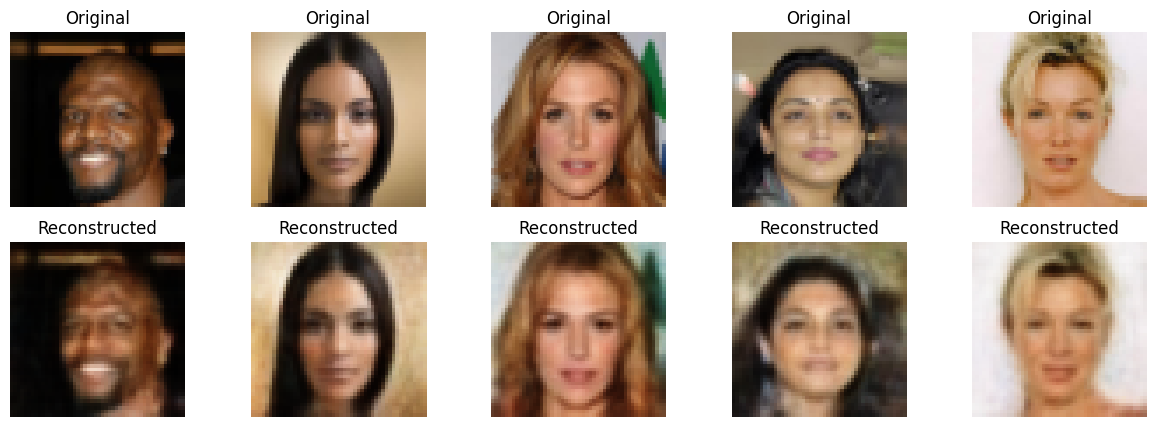

In [50]:
vae = VAE()
#optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
checkpoint = torch.load("human_face_generation_split/20240904_231525_vae/checkpoint_epoch_101.pt", weights_only=True)
vae.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch torchvision.ckpoint['epoch']
#loss = checkpoint['train_loss']
#linear_auto.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
utils.plot_original_and_reconstructed(vae, show_data,device, num_images=5)

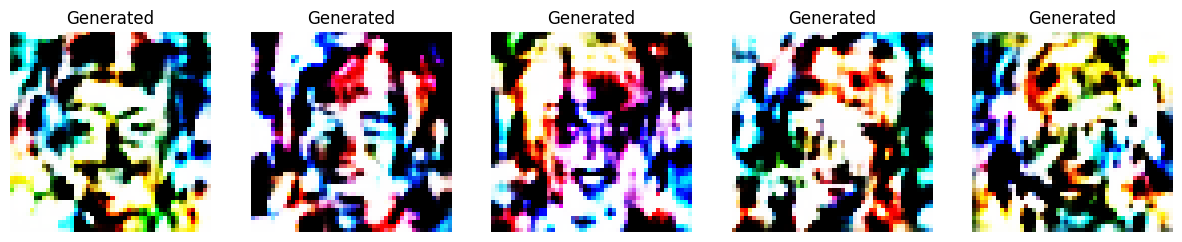

In [52]:
def generate_new_images_vae(model, num_images, latent_dim, device):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Sample from the standard normal distribution
        z = torch.randn(num_images, latent_dim).to(device)
        
        # Pass through the decoder part of the VAE
        generated_images = model.decode(z)  # Ensure your VAE has a decode method

        # Move tensors back to CPU for visualization
        generated_images = generated_images.cpu().numpy()

    # Plot the generated images
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i].transpose(1, 2, 0))  # Transpose for RGB display
        plt.title("Generated")
        plt.axis('off')
    
    plt.show()

# Assuming your VAE has a latent dimension of 512
generate_new_images_vae(vae, num_images=5, latent_dim=512, device=device)